In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.utils import resample
from sklearn.svm import SVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler

pd.set_option('display.max_rows', None)

# Data Analysis

In [2]:
## Read data
train_df = pd.read_csv('train_X.csv')
label_df = pd.read_csv('train_y.csv')
test_df = pd.read_csv('test_X.csv')
test_df_original = pd.read_csv('test_X.csv')

In [3]:
## Check null data
missing_percentage_train = train_df.isnull().mean().sort_values() * 100
# plt.figure(figsize=(5, 12))
# missing_percentage_train.plot(kind='barh', color='skyblue')
# plt.title('train_df: Missing Percentage')   
# plt.show()

missing_percentage_test = test_df.isnull().mean().sort_values() * 100
# plt.figure(figsize=(5, 12))
# missing_percentage_test.plot(kind='barh', color='skyblue')
# plt.title('test_df: Missing Percentage')   
# plt.show()

# Feature Engineering

In [4]:
excluded_features = ['encounter_id', 'patient_id']
train_df_ = train_df.drop(columns=excluded_features)
test_df_ = test_df.drop(columns=excluded_features)

# train_df_.loc[train_df_['apache_4a_icu_death_prob'] < 0, 'apache_4a_icu_death_prob'] = 0
# train_df_.loc[train_df_['apache_4a_hospital_death_prob'] < 0, 'apache_4a_hospital_death_prob'] = 0
# test_df_.loc[test_df_['apache_4a_icu_death_prob'] < 0, 'apache_4a_icu_death_prob'] = 0
# test_df_.loc[test_df_['apache_4a_hospital_death_prob'] < 0, 'apache_4a_hospital_death_prob'] = 0

num_features = train_df_.select_dtypes(include=['float64', 'int64']).columns
cat_features = train_df_.select_dtypes(include=['object']).columns

# train_df_[num_features] = train_df_[num_features].fillna(train_df_[num_features].median())
# train_df_[cat_features] = train_df_[cat_features].fillna(train_df_[cat_features].mode().iloc[0])
# test_df_[num_features] = test_df_[num_features].fillna(test_df_[num_features].median())
# test_df_[cat_features] = test_df_[cat_features].fillna(test_df_[cat_features].mode().iloc[0])

scaler = StandardScaler() 
train_df_[num_features] = scaler.fit_transform(train_df_[num_features])
test_df_[num_features] = scaler.transform(test_df_[num_features])
train_df_ = pd.get_dummies(train_df_, columns=cat_features, drop_first=True)
test_df_ = pd.get_dummies(test_df_, columns=cat_features, drop_first=True)

In [5]:
## Check imbalance
label_percentage = label_df['has_died'].value_counts(normalize=True)
print(label_percentage)
# plt.figure(figsize=(5,5))
# label_percentage.plot(kind='bar', color=['skyblue','salmon'])
# plt.xlabel('Has Died (0: Survived, 1: Died)')
# plt.ylabel('Percentage')
# plt.title('label_percentage')
# plt.show()

## Over sample
train_X_ns = train_df_
train_y_ns = label_df['has_died']
oversample = RandomOverSampler(sampling_strategy='minority')
train_X, train_y = oversample.fit_resample(train_df_, label_df['has_died'])
test_X = test_df_

label_percentage = train_y.value_counts(normalize=True)
print(label_percentage)
# plt.figure(figsize=(5,5))
# label_percentage.plot(kind='bar', color=['skyblue','salmon'])
# plt.xlabel('Has Died (0: Survived, 1: Died)')
# plt.ylabel('Percentage')
# plt.title('label_percentage')
# plt.show()


has_died
0    0.913705
1    0.086295
Name: proportion, dtype: float64
has_died
0    0.5
1    0.5
Name: proportion, dtype: float64


# Model Selection

In [6]:
scoring_metrics = ['f1', 'accuracy', 'roc_auc']

def print_score(model_name, cv_results):
    print(f"[ {model_name} ]")
    print("Average F1 Score:  ", round(cv_results['test_f1'].mean(), 4))
    print("Average AUROC:     ", round(cv_results['test_roc_auc'].mean(), 4))
    print("Average Accuracy:  ", round(cv_results['test_accuracy'].mean(), 4))

In [7]:
model_name = 'Random Forest 300 w/ oversampling'
rf_model_300 = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    class_weight='balanced',
    random_state=42)
rf_scores = cross_validate(estimator=rf_model_300, X=train_X, y=train_y, cv=5, scoring=scoring_metrics)
print_score(model_name, rf_scores)
print("\n")

model_name = 'Random Forest 300 w/o oversampling'
rf_scores_ns = cross_validate(estimator=rf_model_300, X=train_X_ns, y=train_y_ns, cv=5, scoring=scoring_metrics)
print_score(model_name, rf_scores_ns)
print("\n")

model_name = 'Random Forest 400 w/ oversampling'
rf_model_400 = RandomForestClassifier(
    n_estimators=400,
    max_depth=15,
    class_weight='balanced',
    random_state=42)
rf_scores = cross_validate(estimator=rf_model_400, X=train_X, y=train_y, cv=5, scoring=scoring_metrics)
print_score(model_name, rf_scores)
print("\n")


[ Random Forest 300 w/ oversampling ]
Average F1 Score:   0.9685
Average AUROC:      0.9976
Average Accuracy:   0.9678


[ Random Forest 300 w/o oversampling ]
Average F1 Score:   0.4364
Average AUROC:      0.878
Average Accuracy:   0.9177


[ Random Forest 400 w/ oversampling ]
Average F1 Score:   0.9687
Average AUROC:      0.9976
Average Accuracy:   0.9679




In [8]:
### Skip Adaboost because it doesn't accept NaN value in train_X ###
# model_name = 'Adaboost'
# adb_model = AdaBoostClassifier(
#     n_estimators=150, 
#     algorithm='SAMME', 
#     random_state=42)
# adb_scores = cross_validate(estimator=adb_model, X=train_X, y=train_y, cv=5, scoring=scoring_metrics)
# print_score(model_name, adb_scores)
# print("\n")
# adb_scores_ns = cross_validate(estimator=adb_model, X=train_X_ns, y=train_y_ns, cv=5, scoring=scoring_metrics)
# print_score(model_name, adb_scores_ns)

In [9]:
model_name = 'XGBoost w/ oversampling'
xgboost_model = XGBClassifier(
    n_estimators=200, 
    learning_rate=0.1, 
    max_depth=6, 
    scale_pos_weight=1, 
    random_state=42, 
    verbosity=2)
xgboost_scores = cross_validate(estimator=xgboost_model, X=train_X, y=train_y, cv=5, scoring=scoring_metrics)
print_score(model_name, xgboost_scores)
print("\n")

model_name = 'XGBoost w/o oversampling'
xgboost_scores_ns = cross_validate(estimator=xgboost_model, X=train_X_ns, y=train_y_ns, cv=5, scoring=scoring_metrics)
print_score(model_name, xgboost_scores_ns)


[ XGBoost w/ oversampling ]
Average F1 Score:   0.9299
Average AUROC:      0.9761
Average Accuracy:   0.9275


[ XGBoost w/o oversampling ]
Average F1 Score:   0.4464
Average AUROC:      0.8869
Average Accuracy:   0.9298


In [10]:
model_name = 'LGBM w/ oversampling'
lgb_model = LGBMClassifier(
    class_weight='balanced', 
    learning_rate=0.05, 
    n_estimators=200, 
    num_leaves=31, 
    random_state=42,
    verbosity=-1)
lgb_scores = cross_validate(estimator=lgb_model, X=train_X, y=train_y, cv=5, scoring=scoring_metrics)
print_score(model_name, lgb_scores)
print("\n")

model_name = 'LGBM w/o oversampling'
lgb_scoress_ns = cross_validate(estimator=lgb_model, X=train_X_ns, y=train_y_ns, cv=5, scoring=scoring_metrics)
print_score(model_name, lgb_scoress_ns)


[ LGBM w/ oversampling ]
Average F1 Score:   0.8921
Average AUROC:      0.9524
Average Accuracy:   0.8885


[ LGBM w/o oversampling ]
Average F1 Score:   0.4537
Average AUROC:      0.8883
Average Accuracy:   0.8493


# Train

In [11]:
best_model = rf_model_400
best_model.fit(train_X, train_y)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=400,
                       random_state=42)

# Test

In [12]:
test_predictions = best_model.predict(test_X)
prediction_df = pd.DataFrame({
    'patient_id': test_df_original['patient_id'],  
    'pred': test_predictions
})
prediction_df.to_csv('testing_result.csv', index=False)

# Feature Importance

                          Feature  Importance
65       apache_4a_icu_death_prob    0.101188
64  apache_4a_hospital_death_prob    0.097945
21              ventilated_apache    0.030949
13               gcs_motor_apache    0.026073
37                   d1_sysbp_min    0.025421
15              gcs_verbal_apache    0.023309
39       d1_sysbp_noninvasive_min    0.023054
35                    d1_spo2_min    0.022440
12                gcs_eyes_apache    0.021962
1                             age    0.021706
31         d1_mbp_noninvasive_min    0.019661
9             apache_3j_diagnosis    0.019502
29                     d1_mbp_min    0.017607
8              apache_2_diagnosis    0.016921
41                    d1_temp_min    0.016187
20                    temp_apache    0.015979
26               d1_heartrate_max    0.015055
32                d1_resprate_max    0.013780
53                h1_resprate_min    0.013331
2                             bmi    0.013234


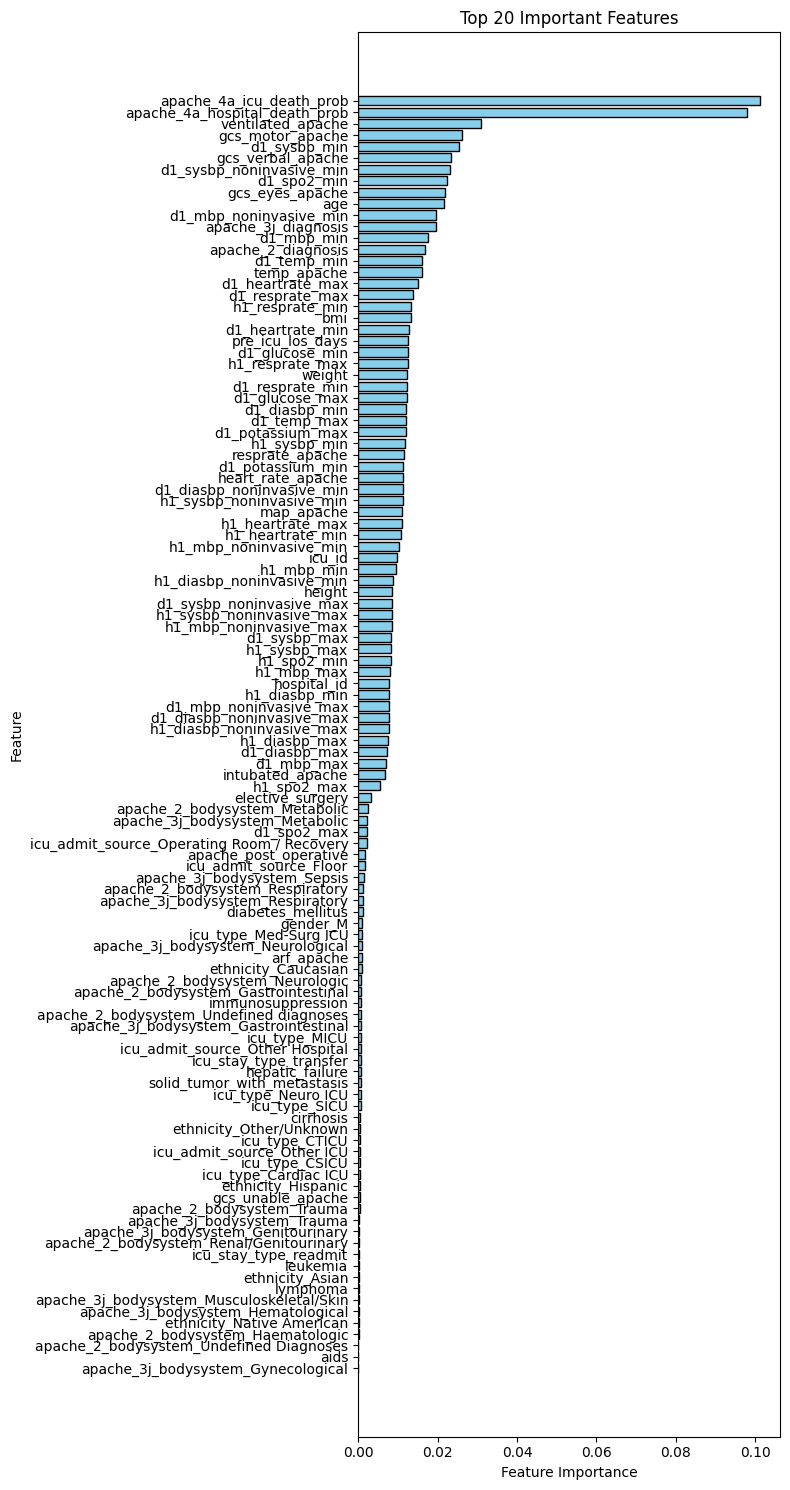

In [15]:
rf = rf_model_300
rf.fit(train_X, train_y)
feature_importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': train_X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

top_20_features = feature_importance_df.head(20)
print(top_20_features)

plt.figure(figsize=(8, 15))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue', edgecolor='black')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Important Features')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()